In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# 讀取CSV資料
file_path = '../mangodata/MangoIrwin.csv'
data = pd.read_csv(file_path)

# 將資料轉換為DataFrame
df = pd.DataFrame(data)

# 篩選出 "台北二" 市場的所有資料並使用 .loc 進行操作
df_taipei2= df.loc[df['市場'] == '台北二'].copy()
# 將'日期'轉換為datetime格式
df_taipei2['日期'] = pd.to_datetime(df_taipei2['日期'])
# 從'日期'中提取年, 月, 日
df_taipei2['年份']= df_taipei2['日期'].dt.year
df_taipei2['月份']= df_taipei2['日期'].dt.month
df_taipei2['日']= df_taipei2['日期'].dt.day

# 移除交易量中的逗號，並轉換為數值型態
df_taipei2['交易量(公斤)'] = df_taipei2['交易量(公斤)'].str.replace(',', '').astype(float)

# 檢查日期欄位是否有重複值，並移除重複日期
df_taipei1 = df_taipei2.drop_duplicates(subset=['日期'])

# 按年份分組並收集日期資料到字典中
year_datas = {}
for year, group in df_taipei2.groupby('年份'):
    year_datas[year] = {
         # 將datetime轉換為字串列表
        '日期': group['日期'].dt.strftime('%Y/%m/%d').tolist(),
        '市場': group['市場'].tolist(),
        '產品': group['產品'].tolist(),
        '上價': group['上價'].tolist(),
        '中價': group['中價'].tolist(),
        '下價': group['下價'].tolist(),
        '平均價(元/公斤)': group['平均價(元/公斤)'].tolist(),
        '交易量(公斤)': group['交易量(公斤)'].tolist()
         
    }
# 創建空的DataFrame來存儲結果
df = pd.DataFrame()

# 迴圈處理每個年份的資料
for year, year_data in year_datas.items():
    # 將資料轉換為DataFrame並將日期轉換為datetime格式
    df_year_data = pd.DataFrame(year_data)
    df_year_data['日期'] = pd.to_datetime(df_year_data['日期'])
    
    # 日期範圍（4月到9月）
    start_date = f'{year}-04-01'
    end_date = f'{year}-09-30'
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 將日期設置為索引
    df_year_data.set_index('日期', inplace=True)

     # 重新索引以包含所有日期
    df_year_data = df_year_data.reindex(date_range)
    
    # 或者使用平均值插補
    df_year_data['平均價(元/公斤)'] = df_year_data['平均價(元/公斤)'].interpolate(method='linear')
    df_year_data['上價'] = df_year_data['上價'].interpolate(method='linear')
    df_year_data['中價'] = df_year_data['中價'].interpolate(method='linear')
    df_year_data['下價'] = df_year_data['下價'].interpolate(method='linear')
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].interpolate(method='linear')

    # 使用前向填充和後向填充來處理剩餘的缺失值
    df_year_data['平均價(元/公斤)'] = df_year_data['平均價(元/公斤)'].ffill().bfill()
    df_year_data['上價'] = df_year_data['上價'].ffill().bfill()
    df_year_data['中價'] = df_year_data['中價'].ffill().bfill()
    df_year_data['下價'] = df_year_data['下價'].ffill().bfill()
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].ffill().bfill()

    # 將交易量(公斤)轉換為整數
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].astype(int)


    # 填充市場和產品欄位
    market_value = year_data['市場'][0] if '市場' in year_data else '未知市場'
    product_value = year_data['產品'][0] if '產品' in year_data else '未知產品'
    df_year_data['市場'] = market_value
    df_year_data['產品'] = product_value

    # 重置索引並添加年份列
    df_year_data.reset_index(inplace=True)
    
    # 將索引顯示到日期欄位
    df_year_data.rename(columns={'index': '日期'}, inplace=True)
    
    # 將處理好的數據添加到結果DataFrame中
    df = pd.concat([df, df_year_data], ignore_index=True)




In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 假設你的 DataFrame 是 df
colx = ['上價', '中價', '下價']
x = df[colx]

coly = ['平均價(元/公斤)']
y = df[coly]

print(x)
print(y)

# 將資料集分為訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 建立和訓練決策樹回歸模型
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

# 預測訓練集和測試集的值
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# 計算評估指標
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train ** 0.5
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# 顯示評估指標
print("訓練集 MSE:", mse_train)
print("訓練集 RMSE:", rmse_train)
print("訓練集 MAE:", mae_train)
print("訓練集 R²:", r2_train)

print("測試集 MSE:", mse_test)
print("測試集 RMSE:", rmse_test)
print("測試集 MAE:", mae_test)
print("測試集 R²:", r2_test)


           上價       中價       下價
0     108.300   73.500   43.700
1     114.150   95.100   74.350
2     120.000  116.700  105.000
3     123.900   95.700   55.600
4     115.425   89.225   54.525
...       ...      ...      ...
1825  137.200   72.500   25.400
1826  130.000   55.900   25.800
1827  136.600   67.700   27.400
1828  168.300   73.800   27.100
1829  156.900   71.300   26.800

[1830 rows x 3 columns]
      平均價(元/公斤)
0        74.500
1        94.750
2       115.000
3        93.300
4        87.525
...         ...
1825     76.000
1826     64.700
1827     73.400
1828     83.300
1829     79.500

[1830 rows x 1 columns]
訓練集 MSE: 1.3794289053045015e-31
訓練集 RMSE: 3.714066377038113e-16
訓練集 MAE: 9.706867974864757e-18
訓練集 R²: 1.0
測試集 MSE: 15.286538782635096
測試集 RMSE: 3.9098003507385255
測試集 MAE: 1.6200364298724956
測試集 R²: 0.9925644949973983


In [8]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = \
    train_test_split(x,y,test_size=0.2)

print(x_train)
print(y_train)


          上價      中價     下價
1789  119.75   57.25  28.55
139    77.10   43.50  24.40
323    82.20   44.00  22.60
570   213.20  137.40  66.60
1262  129.00   84.70  60.60
...      ...     ...    ...
1267  158.80  106.90  76.80
655    49.90   39.20  27.50
157   123.90   59.10  30.20
1441  126.00   61.80  18.30
1062  102.05   47.35  25.10

[1464 rows x 3 columns]
      平均價(元/公斤)
1789      64.00
139       46.40
323       47.40
570      138.40
1262      88.70
...         ...
1267     111.30
655       39.00
157       66.30
1441      66.00
1062      53.85

[1464 rows x 1 columns]


           上價       中價       下價
0     108.300   73.500   43.700
1     114.150   95.100   74.350
2     120.000  116.700  105.000
3     123.900   95.700   55.600
4     115.425   89.225   54.525
...       ...      ...      ...
1825  137.200   72.500   25.400
1826  130.000   55.900   25.800
1827  136.600   67.700   27.400
1828  168.300   73.800   27.100
1829  156.900   71.300   26.800

[1830 rows x 3 columns]
      平均價(元/公斤)
0        74.500
1        94.750
2       115.000
3        93.300
4        87.525
...         ...
1825     76.000
1826     64.700
1827     73.400
1828     83.300
1829     79.500

[1830 rows x 1 columns]
訓練集 MSE: 1.3794289053045015e-31
訓練集 RMSE: 3.714066377038113e-16
訓練集 MAE: 9.706867974864757e-18
訓練集 R²: 1.0
測試集 MSE: 12.0371618852459
測試集 RMSE: 3.4694613249387722
測試集 MAE: 1.6211748633879786
測試集 R²: 0.9941450200933293


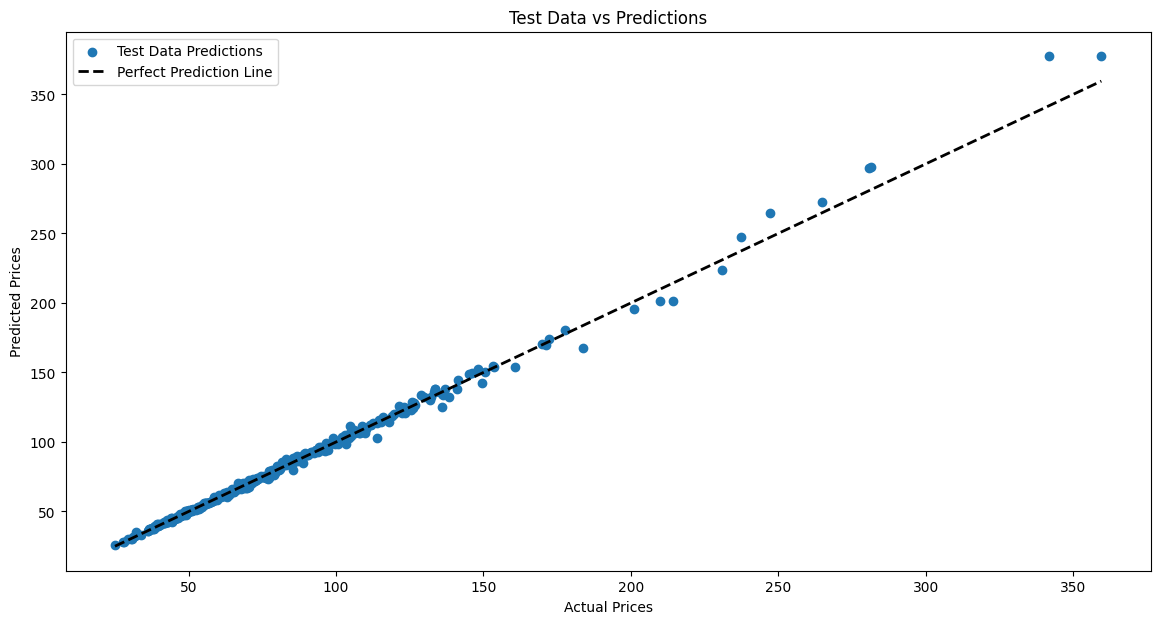

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 假設你的 DataFrame 是 df
colx = ['上價', '中價', '下價']
x = df[colx]

coly = ['平均價(元/公斤)']
y = df[coly]

print(x)
print(y)

# 將資料集分為訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 建立和訓練決策樹回歸模型
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

# 預測訓練集和測試集的值
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# 計算評估指標
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train ** 0.5
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# 顯示評估指標
print("訓練集 MSE:", mse_train)
print("訓練集 RMSE:", rmse_train)
print("訓練集 MAE:", mae_train)
print("訓練集 R²:", r2_train)

print("測試集 MSE:", mse_test)
print("測試集 RMSE:", rmse_test)
print("測試集 MAE:", mae_test)
print("測試集 R²:", r2_test)

# 繪製結果
plt.figure(figsize=(14, 7))

# 繪製測試數據和測試預測的散佈圖
plt.scatter(y_test, y_pred_test, label='Test Data Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Test Data vs Predictions')
plt.legend()
plt.show()


訓練集 MSE: 0.0
訓練集 RMSE: 0.0
訓練集 MAE: 0.0
訓練集 R²: 1.0
測試集 MSE: 13.211340695203397
測試集 RMSE: 3.634740801653317
測試集 MAE: 1.5857468123861562
測試集 R²: 0.9935738893396948


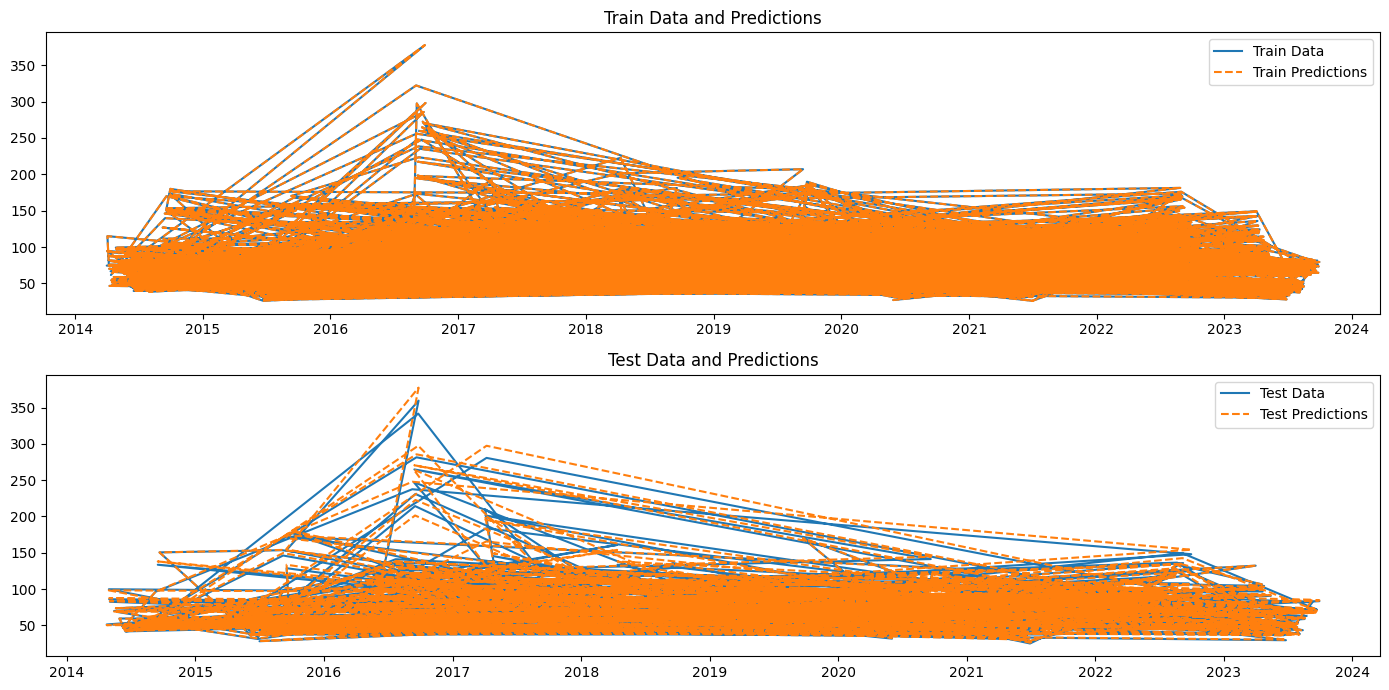

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 假設你的 DataFrame 是 df
colx = ['上價', '中價', '下價']
coly = ['平均價(元/公斤)']
col_date = ['日期']

x = df[colx]
y = df[coly]
dates = df[col_date]

# 分割資料集時保持日期對應
x_train, x_test, y_train, y_test, dates_train, dates_test = train_test_split(
    x, y, dates, test_size=0.2, random_state=42)

# 建立和訓練決策樹回歸模型
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

# 預測訓練集和測試集的值
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# 計算評估指標
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mse_train ** 0.5
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# 顯示評估指標
print("訓練集 MSE:", mse_train)
print("訓練集 RMSE:", rmse_train)
print("訓練集 MAE:", mae_train)
print("訓練集 R²:", r2_train)

print("測試集 MSE:", mse_test)
print("測試集 RMSE:", rmse_test)
print("測試集 MAE:", mae_test)
print("測試集 R²:", r2_test)

# 繪製結果
plt.figure(figsize=(14, 7))

# 繪製實際數據和訓練預測
plt.subplot(2, 1, 1)
plt.plot(dates_train, y_train, label='Train Data')
plt.plot(dates_train, y_pred_train, label='Train Predictions', linestyle='--')
plt.legend()
plt.title('Train Data and Predictions')

# 繪製測試數據和測試預測
plt.subplot(2, 1, 2)
plt.plot(dates_test, y_test, label='Test Data')
plt.plot(dates_test, y_pred_test, label='Test Predictions', linestyle='--')
plt.legend()
plt.title('Test Data and Predictions')

plt.tight_layout()
plt.show()
